In [13]:
import random
import colorednoise as cn
import pandas as pd
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import yaml
import torch.nn.functional as F
from torchlibrosa.augmentation import SpecAugmentation
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from IPython.display import Audio
from efficientnet_pytorch import EfficientNet
sys.path.append("../input/modules")
import datasets
from datasets import RainForestDataset
from datasets.augmentation import *
from utils import logmelfilterbank
from utils import read_hdf5
from utils import down_sampler
from utils import get_concat_down_frame
from utils import get_down_sample_matrix
from models.conformer import *
from models import *
from losses import FrameClipLoss
from datasets import FeatTrainCollater
from datasets import FeatEvalCollater
from utils import lwlrap
sys.path.append("../input/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
submission = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()
tp_list = train_tp["recording_id"].unique()
fp_list = train_fp["recording_id"].unique()

In [ ]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

In [ ]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

In [ ]:
path = "dump/wave/train/551385b05.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp = read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
matrix_fp = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")

# plt.figure(figsize=(16, 8))
# plt.subplot(2, 2, 1)
# plt.plot(wave)
# plt.subplot(2, 2, 2)
# plt.imshow(mel.T, aspect="auto")
# plt.colorbar()
# plt.subplot(2, 2, 3)
# plt.imshow(matrix_tp.T, aspect="auto")
# plt.subplot(2, 2, 4)
# plt.imshow(matrix_fp.T, aspect="auto")
# plt.colorbar()

In [ ]:
y_frame = torch.stack([torch.tensor(down_sampler(matrix_tp[3000:3512])), torch.tensor(down_sampler(matrix_tp[4500:5012]))], dim=0)
y_clip = torch.tensor((y_frame>0).any(axis=1), dtype=torch.float)
x_batch = torch.stack([torch.tensor(mel[3000:3512]), torch.tensor(mel[4500:5012])], dim=0).transpose(2,1)
print(y_frame.shape, y_clip.shape)
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=24,
        training=False,
        require_prep=False,
        is_spec_augmenter=False,
        mixup_lambda=None,)
model.bn0 = nn.BatchNorm2d(128)
y = model(x_batch)
bce = nn.BCEWithLogitsLoss(reduction="mean")
print(y["y_frame"].shape, y["y_clip"].shape)

In [ ]:
criterion = FrameClipLoss()
loss = criterion(y["y_frame"], y_frame, y["y_clip"], y_clip)
print(loss.item())
loss.backward(retain_graph=True)
# clip_loss = bce(y["y_clip"], y_clip)
# frame_loss = bce(y["y_frame"], y_frame)
# print(clip_loss.item())
# print(frame_loss.item())
# clip_loss.backward(retain_graph=True)
# frame_loss.backward(retain_graph=True)


In [10]:
columns = ["recording_id"] + [f"s{i}" for i in range(24)]
ground_truth = pd.DataFrame(np.zeros((len(tp_list), 25)), columns=columns)
ground_truth["recording_id"] = train_tp["recording_id"].unique()
for i, recording_id in enumerate(train_tp["recording_id"].values):
    ground_truth.iloc[ground_truth["recording_id"]==recording_id, train_tp.loc[i, "species_id"]+1] = 1.0

kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y = ground_truth.iloc[:, 1:].values
for i, (train_idx, valid_idx) in enumerate(kfold.split(y, y)):
    train_y = ground_truth.iloc[train_idx]
    valid_y = ground_truth.iloc[valid_idx]
    if i == 0:
        break
train_dataset = RainForestDataset(
    root_dirs=["dump/wave/train"],
    train_tp=train_tp,
    train_fp=None,
    keys=["feats"],
    mode="tp",
    is_normalize=False,
    allow_cache=False,
    seed=None,
)
eval_dataset = RainForestDataset(
    files=[
        os.path.join("dump/wave/train", f"{recording_id}.h5")
        for recording_id in tp_list[valid_idx]
    ],
    keys=["feats", "matrix_tp"],
    mode="test",
    is_normalize=False,
    allow_cache=False,
    seed=None,
        )

train_collater = FeatTrainCollater(
    max_frames=512,
    l_target=16,
    mode="binary",
    random=False
)
eval_collater = FeatEvalCollater(
    max_frames=512,
    n_split=3,
    is_label=True,
)
data_loader = {
"train": DataLoader(
        dataset=train_dataset,
        batch_size=64,
        collate_fn=train_collater,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
    ),
"eval": DataLoader(
        eval_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=eval_collater,
        num_workers=1,
        pin_memory=False,
    ),
}
clip_list = []
for i, batch in enumerate(data_loader["train"]):
    x = batch["X"]
    y_frame = batch["y_frame"]
    y_clip = batch["y_clip"]
    clip_list.append(y_clip)
    print(x.shape)
    print(y_frame.shape)
    print(y_clip.shape)
    if i == 0:
        break

torch.Size([64, 128, 512])
torch.Size([64, 16, 25])
torch.Size([64, 25])


In [ ]:
x1 = []
y1_clip = []
beginnings1 = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
    beginnings1.append(batch["beginnings"])
    if i == 0:
        break
x2 = []
y2_clip = []
beginnings2 = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])
    beginnings2.append(batch["beginnings"])
    if i == 0:
        break
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

In [ ]:
x1 = []
y1_clip = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
x2 = []
y2_clip = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])


In [ ]:
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

In [ ]:
xx1.shape

In [ ]:
mode = "valid"
n_eval_split = 3
device = "cpu"
n_class = 24
l_spec = 16
keys_list = [f"X{i}" for i in range(n_eval_split)]
y_clip = [
    torch.empty((0, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_frame = [
    torch.empty((0, l_spec, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_clip_true = torch.empty((0, n_class))
model.eval()
with torch.no_grad():
    for batch in data_loader["eval"]:
        if mode == "valid":
            y_clip_true = torch.cat([y_clip_true, batch["y_clip"]], dim=0)
        x_batchs = [batch[key].to(device) for key in keys_list]
        for i in range(n_eval_split):
            y_batch_ = model(x_batchs[i])
            y_clip[i] = torch.cat([y_clip[i], y_batch_["y_clip"]], dim=0)
            y_frame[i] = torch.cat([y_frame[i], y_batch_["y_frame"]], dim=0)
# (B, n_eval_split, n_class)
y_clip = torch.stack(y_clip, dim=0).detach().cpu().numpy()
# (B, n_eval_split, T, n_class)
y_frame = torch.stack(y_frame, dim=0).detach().cpu().numpy()
if mode == "valid":
    y_clip_true = y_clip_true.numpy()
    score = lwlrap(y_clip_true, y_clip.max(axis=0))
    print(f"score:{score:.6f}")


In [41]:
ground_truth = pd.read_csv("../input/rfcx-species-audio-detection/ground_truth.csv")
tag = "v002-clip065"
type = "wave"
with open(f"conf/tuning/Cnn14_DecisionLevelAtt.{tag}.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)
oof_path = f"exp/{type}/Cnn14_DecisionLevelAtt/{tag}/best_score/oof.h5"
y_clip = read_hdf5(oof_path, "y_clip")
y_frame = read_hdf5(oof_path, "y_frame")
print(y_clip.shape, y_frame.shape)

(1132, 20, 24) (1132, 20, 16, 24)


In [46]:
a = np.stack(y_frame, axis=1)
a.shape

(20, 1132, 16, 24)

In [42]:
idx = 6
recording_id = ground_truth.loc[idx, "recording_id"]
print(recording_id)
dump_path = f"dump/{type}/train/{recording_id}.h5"
idx_matrix = read_hdf5(dump_path, "matrix_tp")
l_original = len(idx_matrix)
ground_truth_frame = get_down_sample_matrix(idx_matrix, l_target=config["l_target"], max_frames=config["max_frames"], n_eval_split=config["n_eval_split"], mode="binary")
concat_y_frame = get_concat_down_frame(y_frame[idx], l_original=l_original, max_frames=config["max_frames"])
concat_ground_truth = get_concat_down_frame(ground_truth_frame, l_original=l_original, max_frames=config["max_frames"])

true_clip = idx_matrix.any(axis=0).astype(np.int64)[:24].reshape(1, -1)
pred_clip = y_clip[idx].max(axis=0)[:24].reshape(1, -1)
pred_frame_clip = concat_y_frame.max(axis=0)[:24].reshape(1, -1)
score1 = lwlrap(true_clip, pred_clip)
score2 = lwlrap(true_clip, pred_frame_clip)
score3 = lwlrap(true_clip, pred_clip+pred_frame_clip)

print(f"clip:{score1:.5f}, frame: {score2:.5f}, ensemble: {score3:.5f}")

00d442df7
clip:0.50000, frame: 0.50000, ensemble: 0.50000


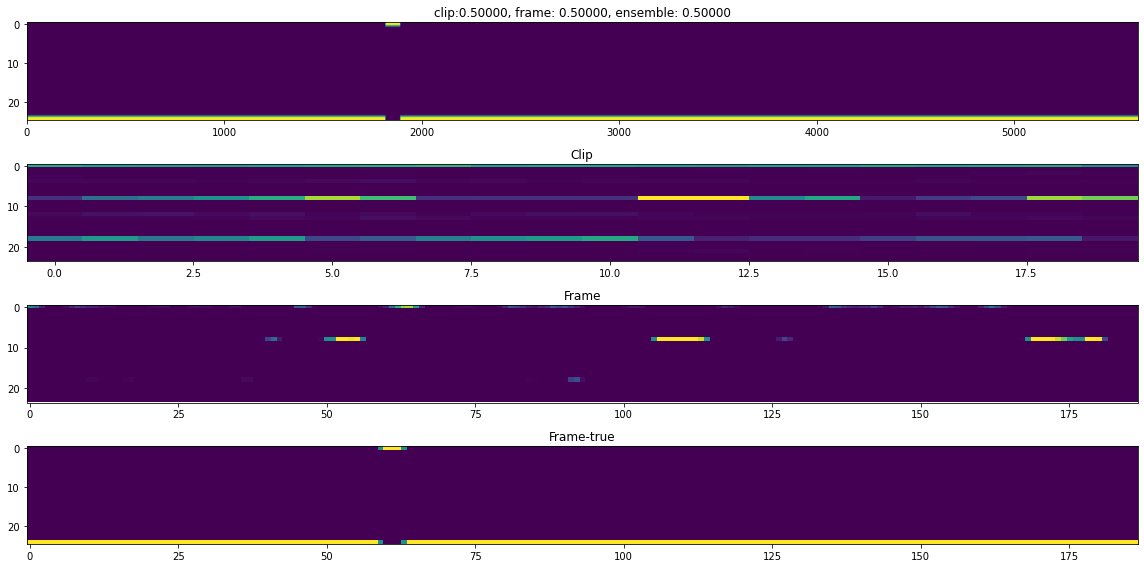

In [43]:
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.title(f"clip:{score1:.5f}, frame: {score2:.5f}, ensemble: {score3:.5f}")
plt.imshow(idx_matrix.T, aspect="auto")
plt.subplot(4, 1, 2)
plt.title("Clip")
plt.imshow(y_clip[idx].T, aspect="auto")
plt.subplot(4, 1, 3)
plt.title("Frame")
plt.imshow(concat_y_frame.T, aspect="auto")
plt.subplot(4, 1, 4)
plt.title("Frame-true")
plt.imshow(concat_ground_truth.T, aspect="auto")
plt.tight_layout()

In [ ]:
plt.imshow(concat_y_frame.T, aspect="auto")

In [ ]:
plt.plot(pred_frame_clip.flatten(), alpha=0.5)
plt.plot(true_clip.flatten(), alpha=0.5)

In [ ]:
config["max_frames"]

In [ ]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
x1 = torch.stack([x,x,x]).transpose(1,0)
conv1 = nn.Conv2d(1, 3, 1, 1)
conv_out = conv1(x.unsqueeze(1))
conv_out.shape

In [ ]:
for name,_ in model.named_parameters():
    print(name)

In [ ]:
x = resnext50_32x4d.conv1(x1)
print(x.shape)
x = resnext50_32x4d.bn1(x)
print(x.shape)
x = resnext50_32x4d.relu(x)
print(x.shape)
x = resnext50_32x4d.maxpool(x)
print(x.shape)
x = resnext50_32x4d.layer1(x)
print(x.shape)
x = resnext50_32x4d.layer2(x)
print(x.shape)
x = resnext50_32x4d.layer3(x)
print(x.shape)
x = resnext50_32x4d.layer4(x)
print(x.shape)
x = resnext50_32x4d.avgpool(x)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)
y1 = resnext50_32x4d.fc(x)
print(y1.shape)

In [ ]:
model = ResNext50(num_mels=128,
        classes_num=25,
        training=False,
        is_spec_augmenter=True)
yy = model(x)

In [ ]:
print(yy["y_frame"].shape, yy["y_clip"].shape, yy["embedding"].shape)

In [ ]:
from IPython.display import Audio
sr = 48000
i = 5
path = f"dump/wave/train/{tp_list[i]}.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
feats = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp= read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
# transform = TimeStretch(always_apply=True, max_rate=1.1)
# transform = GaussianNoiseSNR(always_apply=True, min_snr=40.0, max_snr=40.0)
# transform = VolumeControl(always_apply=True,db_limit=10, mode="cosine")
# # transform =PinkNoiseSNR(always_apply=True, min_snr=50.0, max_snr=50.0)
# transform = Compose([
# #   OneOf([
# #     GaussianNoiseSNR(min_snr=10),
# #     PinkNoiseSNR(min_snr=10)
# #   ]),
# #   VolumeControl(mode="sine")
#     PitchShift(max_steps=2, sr=sr)
# ])
wave_ = transform(wave)
feats_ = logmelfilterbank(wave_, sr, fft_size=2048,hop_size=512,window="hann",num_mels=128,fmin=50,fmax=16000)
plt.figure(figsize=(16, 6))
plt.subplot(3, 1, 1)
plt.imshow(matrix_tp.T, aspect="auto")
plt.colorbar()
plt.subplot(3, 1, 2)
plt.title("Original")
plt.imshow(feats.T, aspect="auto")
plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(feats_.T, aspect="auto")
plt.title("Augmented")
plt.colorbar()
plt.tight_layout()
# Audio(wave, rate=sr)

In [ ]:
# Audio(wave_, rate=sr)

In [ ]:
# model = ConformerEncoderDecoder(
#     num_features=128,
#     num_classes=24,
#     num_blocks=8,
#     num_channels=144,
#     kernel_size=31,
#     num_heads=4,
#     num_latent_units=32,
#     num_embeddings=0,
#     embedding_dim=0,
#     concat_embedding=False,
#     dropout=0.1,
#     bias=True,
#     use_bottleneck=True,
#     use_reconstruct=True,
#     use_dializer=True,
#     is_spec_augmenter=True,
#     training=True,
#     )
model = TransformerEncoderDecoder(
    num_features=128,
    num_classes=24,
    sequence_length=-1,
    input_layer= "linear",
    num_blocks= 4,
    num_heads= 4,
    num_hidden_units= 64,
    num_feedforward_units = 128,
    num_latent_units =8,
    num_embeddings=0,
    embedding_dim=0,
    concat_embedding=False,
    activation="relu",
    use_position_encode=False,
    max_position_encode_length=512,
    dropout=0.1,
    use_reconstruct=True,
    use_dializer=True,
    is_spec_augmenter=True,
    training=True,
)

In [ ]:
# batch["X_"] = torch.rand(64, 128, 513)
print(batch["X"].transpose(2,1).shape)
y = model(batch["X"].transpose(2,1))
print(y["y_frame"].shape, y["y_clip"].shape)
print(y["frame_mask"].shape)
print(y["reconstructed"].shape)

In [48]:
model = models.mobilenet_v2(pretrained=True)


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

In [52]:
conv1 = nn.Conv2d(1, 3, 1, 1)
x = conv1(batch["X"].unsqueeze(1))
y_ = model.features(x)
print(y_.shape)

torch.Size([64, 1280, 4, 16])


In [32]:
model = EfficientNet_b()
y = model(batch["X"])

Loaded pretrained weights for efficientnet-b0


(array([2.0000e+00, 3.0000e+00, 2.6000e+01, 2.9200e+02, 2.3450e+03,
        1.2177e+04, 8.4270e+03, 1.1490e+03, 1.3300e+02, 2.2000e+01]),
 array([-32.66062  , -27.081799 , -21.502975 , -15.924152 , -10.345329 ,
         -4.766506 ,   0.8123169,   6.39114  ,  11.969963 ,  17.548786 ,
         23.12761  ], dtype=float32),
 <BarContainer object of 10 artists>)

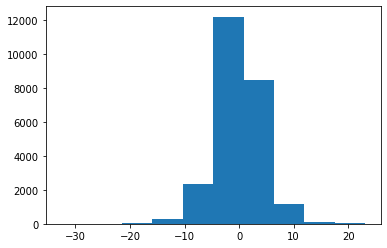

In [55]:
plt.hist(y["y_frame"].detach().numpy().flatten())

In [56]:
a = np.arange(24).reshape(2,3,4).max(axis=1)

In [57]:
a

array([[ 8,  9, 10, 11],
       [20, 21, 22, 23]])